En esta sección se trabajará con denoising autoencoder (dAE), que corresponde esencialmente a un autoencoder entrenado
para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En este documento se explorará la aplicación más "natural" o "directa" del método.

***a)*** Se procede a generar artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $\textbf{x} \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde{\textbf{x}}$ se obtiene
como $\tilde{\textbf{x}} = \textbf{x} \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in \mathbb{R}^d$ es un vector aleatorio binario con componentes $\text{Ber}(p)$ independientes.

In [1]:
from numpy.random import binomial
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalizacion de imagenes
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Transformación en vectores R^{784}
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Creación conjunto de validación
nval = 5000
x_val = x_train[-nval:]
y_val = y_train[-nval:]
x_train = x_train[:-nval]
y_train = y_train[:-nval]

# Transformación de salidas a probabilidades de activación
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

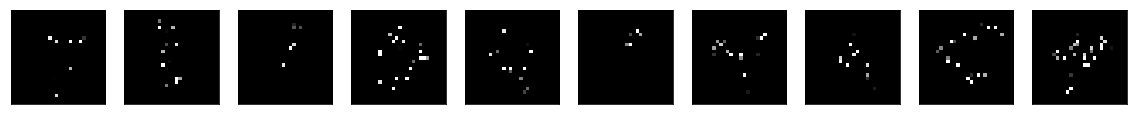

In [3]:
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***b)*** A continuación se entrena un autoencoder para reconstruir las imágenes corruptas generadas en el ítem anterior. Para evaluar la calidad de la reconstrucción se utilizará el mismo error de reconstrucción de la sección *3.1* y se evaluará cualitativamente por medio de la visualización de la imagen corrupta y reconstruida. Se experimenta con diferentes valores de p en el rango (0, 1).

In [ ]:
noise_levels = [0.1,0.2,0.4,0.6,0.8,1.0]
i = 0

for noise_level in noise_levels:
    i += 1
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, validation_data=(noisy_x_val, x_val))
    autoencoder.save("autoencoder"+str(i)+".h5")
    encoder.save("encoder"+str(i)+".h5")
    decoder.save("decoder"+str(i)+".h5")

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_2, outputs=sigmoid.0)`
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 10s - loss: 0.3133 - val_loss: 0.2684

***c)***  Análogamente a a), se procede a generar artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (Gaussian noise): si $\textbf{x} \in \mathbb{R}^d$ es una de las imágenes originales, la versión ruidosa $\tilde{\textbf{x}}$ se obtiene
como $\tilde{\textbf{x}} = \textbf{x} + \xi$ donde $\xi \in \mathbb{R}^d$ es un vector aleatorio con componentes $\mathcal{N} (0,\sigma^2)$ independientes.

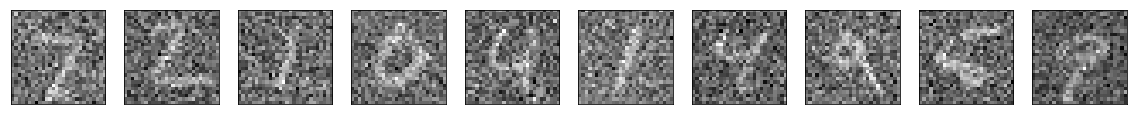

In [4]:
from numpy.random import standard_normal
devst = 0.5
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train + noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val + noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test + noise_mask

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***d)***

In [1]:
devsts = [0.1,0.3,0.5,0.7,0.9,1.0]
i = 0

for devsts in devsts:
    i += 1
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train+noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val+noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test+noise_mask

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True, validation_data=(noisy_x_val, x_val))
    autoencoder.save("autoencoder_2_"+str(i)+".h5")
    encoder.save("encoder_2_"+str(i)+".h5")
    decoder.save("decoder_2_"+str(i)+".h5")

NameError: name 'devst' is not defined

*** e)*** esta no la pude entender jaja. La dejo para el final para darle una vuelta con calma.